Associate each image with a unique arrival time depending on what time it represents in C3. Pass batches of frames and param values through a conv NODE, followed by fully connected layers to predict the arrival time of the image.

We explore two methods of parameter augmentation: Concatenation to flattened output of conv prior to passing through linear layer vs affine transformation of conv output with scale and bias learnt through additional linear layers i.e. FiLM modulation - https://arxiv.org/pdf/1709.07871

In [1]:
import sys
import torch
import torch.nn
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
args = {
    "niters":400,
    "lr": 0.001,
    "save": "arr_experiments/",
    "load": None,
    "r": 1991,
    "resize_dims": (16, 64),
    "param_scaling": [1, 1],
    "warm_start": 20376,
    "do_warm_start": False,
    # "loss": "smooth_l1",
    "loss": "mae",
    # "loss": "mse",
    "batch_size": 32,
    "dropout":False
}

In [3]:
import torch.nn as nn

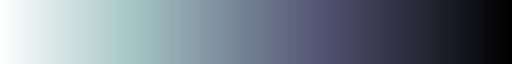

In [4]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

In [5]:
import time
import datetime
import argparse
from random import SystemRandom

from rich.progress import track
import tqdm

import matplotlib.pyplot as plt

import cnn_utils as cu

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

Filter out runs which arrive very late.

In [10]:
arr_times_data = pd.read_csv("./data_surrogate/UShift_CME3_120runs.csv")
arr_times_data = arr_times_data.dropna()

arr_times_data

,SIMID,shift,Tshock_sim,Tshock_obs
0,1,-18.0,70.0,52
2,3,-15.0,67.0,52
3,4,-7.0,59.0,52
4,5,-22.0,74.0,52
6,7,-4.0,56.0,52
...,...,...,...,...
114,116,7.0,45.0,52
115,117,19.0,33.0,52
116,118,16.0,36.0,52
117,119,5.0,47.0,52


In [11]:
data_sim_ids = arr_times_data['SIMID'].to_numpy()
data_arr_time = arr_times_data['Tshock_sim'].to_numpy()
data_shifts = arr_times_data['shift'].to_numpy()

In [12]:
# First split sim_ids, and arr_time into train and test.
# Based on this load param file for sims and index that

In [13]:
num_sim = len(data_sim_ids)
print(num_sim)

# train_size = np.int64(num_sim * 0.6)
# valid_size = np.int64(num_sim * 0.2)
# test_size = num_sim - train_size - valid_size
# print(train_size, valid_size, test_size)

train_frac, valid_frac, test_frac = 0.6, 0.15, 0.25

113


In [14]:
generator1 = torch.Generator().manual_seed(2024)
train_valid_test = random_split(data_sim_ids, 
                                [train_frac, valid_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)


In [15]:
data_sim_ids

array([  1,   3,   4,   5,   7,   9,  10,  11,  12,  13,  15,  16,  17,
        18,  19,  20,  21,  23,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120])

In [16]:
train_idx = np.array(train_valid_test[0].indices)
valid_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

In [17]:
train_sims = data_sim_ids[train_idx] - 1
val_sims = data_sim_ids[valid_idx] - 1
test_sims = data_sim_ids[test_idx] - 1

In [18]:
train_idx

array([  7,  43,  63,  33,  38,  73,  66,  20,  46,  80,  32,  21,  52,
        91, 101, 105,  35, 109,  19,  61,  82,  72,  92,  81,  90,   9,
        85,  39,  70,  40,  22,  45,  95,  24,  12,  97,   5,  67,  84,
        74, 110,  30,  71, 100,  37,  98, 102,  94,  57,  53,  75,  83,
       107,  42,  68,  69,  15,  59,  26,  10, 103, 112,  14,  56,  29,
       111,  87,  49])

In [19]:
ntrain = train_idx.shape[0]
nval = valid_idx.shape[0]
ntest = test_idx.shape[0]
ntrain, nval, ntest

(68, 17, 28)

In [20]:
all_idx = np.concatenate((train_idx, valid_idx, test_idx), axis=0)

In [21]:
all_idx.min(), all_idx.max()

(0, 112)

In [22]:
data_arr_time.shape

(113,)

In [23]:
data_arr_time

array([70., 67., 59., 74., 56., 88., 59., 85., 73., 86., 89., 52., 53.,
       78., 69., 67., 55., 61., 54., 59., 74., 71., 67., 51., 73., 56.,
       63., 51., 77., 62., 63., 72., 51., 49., 50., 74., 46., 71., 55.,
       61., 55., 67., 46., 65., 69., 56., 54., 51., 53., 64., 49., 44.,
       56., 50., 55., 47., 54., 73., 46., 43., 53., 66., 44., 38., 45.,
       54., 46., 46., 58., 50., 53., 47., 56., 43., 52., 39., 50., 63.,
       55., 40., 41., 56., 44., 38., 47., 62., 41., 40., 47., 38., 58.,
       39., 44., 37., 45., 49., 42., 39., 47., 35., 42., 33., 40., 40.,
       41., 36., 40., 41., 45., 33., 36., 47., 32.])

Split `data_arr_time` into multiple targets. If the time is T1 for a given sim, split it into T1-50, T1 - 52, ..., T1 - 180 to associate each image of a time series for parameter $\mu$ with a unique target.

In [24]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 50 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1



# scale time appropriately
tt_raw = np.linspace(all_timesteps[tMinIdx], all_timesteps[tMaxIdx], nTimesteps)
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)

nTimesteps, tt_raw

(40,
 array([102., 104., 106., 108., 110., 112., 114., 116., 118., 120., 122.,
        124., 126., 128., 130., 132., 134., 136., 138., 140., 142., 144.,
        146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180.]))

In [25]:
data_arr_time_all_timesteps = np.zeros((num_sim, nTimesteps))
for i in range(num_sim):
    data_arr_time_all_timesteps[i, :] = data_arr_time[i] - (tt_raw / 60.0)

In [26]:
data_arr_time[2]

59.0

In [27]:
train_idx

array([  7,  43,  63,  33,  38,  73,  66,  20,  46,  80,  32,  21,  52,
        91, 101, 105,  35, 109,  19,  61,  82,  72,  92,  81,  90,   9,
        85,  39,  70,  40,  22,  45,  95,  24,  12,  97,   5,  67,  84,
        74, 110,  30,  71, 100,  37,  98, 102,  94,  57,  53,  75,  83,
       107,  42,  68,  69,  15,  59,  26,  10, 103, 112,  14,  56,  29,
       111,  87,  49])

In [28]:
# now split the all timesteps array correctly.

In [29]:
import sklearn
import copy

In [74]:
train_arr_raw = data_arr_time_all_timesteps[train_idx, :]
val_arr_raw = data_arr_time_all_timesteps[valid_idx, :]
test_arr_raw = data_arr_time_all_timesteps[test_idx, :]

print(train_arr_raw.shape, val_arr_raw.shape, test_arr_raw.shape)

# pt = PowerTransformer(method='box-cox')
pt = sklearn.preprocessing.RobustScaler()
# pt = sklearn.preprocessing.MinMaxScaler()
pt.fit(train_arr_raw.reshape(-1, 1))

train_arr_pt = pt.transform(train_arr_raw.reshape(-1, 1)).reshape(ntrain, nTimesteps)
val_arr_pt = pt.transform(val_arr_raw.reshape(-1, 1)).reshape(nval, nTimesteps)
test_arr_pt = pt.transform(test_arr_raw.reshape(-1, 1)).reshape(ntest, nTimesteps)

# train_arr_pt = copy.deepcopy(train_arr_raw)
# val_arr_pt = copy.deepcopy(val_arr_raw)
# test_arr_pt = copy.deepcopy(test_arr_raw)

(68, 40) (17, 40) (28, 40)


(array([200., 480., 470., 390., 345., 305., 210., 160.,   0., 160.]),
 array([29.  , 34.83, 40.66, 46.49, 52.32, 58.15, 63.98, 69.81, 75.64,
        81.47, 87.3 ]),
 <BarContainer object of 10 artists>)

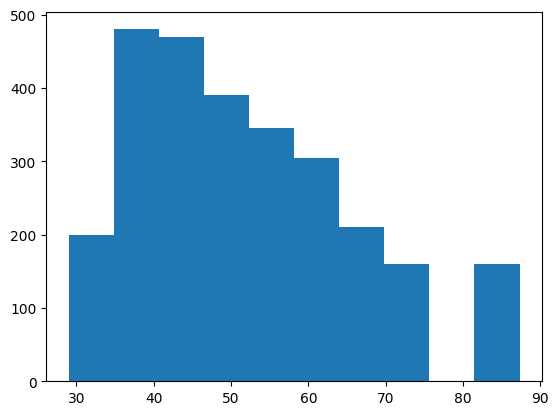

In [31]:
plt.hist(train_arr_raw.flatten())

(array([200., 480., 470., 390., 345., 305., 210., 160.,   0., 160.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

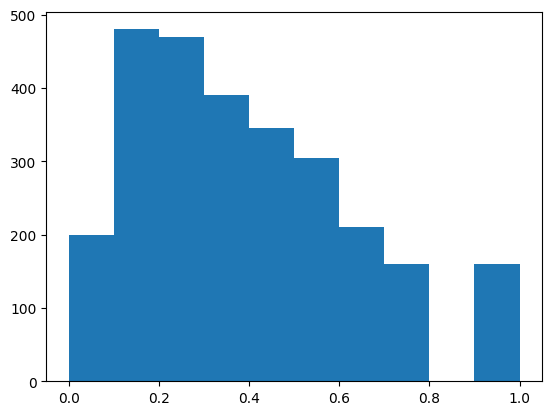

In [32]:
plt.hist(train_arr_pt.flatten())

In [33]:
# Process image datasets in pretty much the same way as before.

In [34]:
raw_datafile = np.load("./data_surrogate/CR2192_120runs_C3_ratio_PolarTensor.npy")

In [35]:
raw_datafile.shape

(128, 512, 90, 120)

In [36]:
raw_min, raw_max = raw_datafile.min(), raw_datafile.max()
raw_min, raw_max

(0.799298967364635, 1.5)

In [37]:
train_data_raw = raw_datafile[:, :, :, train_sims]
val_data_raw = raw_datafile[:, :, :, val_sims]
test_data_raw = raw_datafile[:, :, :, test_sims]

In [38]:
resize_dims = args["resize_dims"]

train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))
    
val_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))

test_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [39]:
max_train = torch.max(train_data_resized)
min_train = torch.min(train_data_resized)

max_train, min_train

(tensor(1.5000), tensor(0.8940))

In [40]:
train_data = (train_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)

In [41]:
train_data.shape, val_data.shape, test_data.shape

(torch.Size([68, 40, 16, 64]),
 torch.Size([17, 40, 16, 64]),
 torch.Size([28, 40, 16, 64]))

In [42]:
train_data.max(), val_data.max(), test_data.max()

(tensor(1.), tensor(1.), tensor(1.))

### Concatenate parameters (optional)

In [43]:
raw_params = pd.read_csv("./data_surrogate/params_2192_120runs.csv")
raw_params = raw_params[["BStrength", "OrientationCme", "ApexHeight", "iHelicity"]]
raw_params

,BStrength,OrientationCme,ApexHeight,iHelicity
0,5.0417,347.475,0.8505,-1
1,5.1250,330.225,0.7196,1
2,6.7917,380.475,0.7482,1
3,5.3750,342.225,0.9123,-1
4,5.2917,322.725,0.8719,1
...,...,...,...,...
115,14.6250,300.225,0.6911,1
116,14.7083,371.475,0.9337,1
117,14.7917,348.225,0.7743,1
118,14.8750,312.975,0.7363,-1


In [44]:
raw_params.agg(['min', 'max'])

,BStrength,OrientationCme,ApexHeight,iHelicity
min,5.0417,294.975,0.6673,-1
max,14.9583,384.225,0.9504,1


In [45]:
raw_params_retained = raw_params.to_numpy()[data_sim_ids - 1, :]
raw_params_retained.shape

(113, 4)

In [46]:
# raw_params_np = raw_params_retained.to_numpy()

In [47]:
param_scaling = [15, 384, 0.95, 1]

In [48]:
raw_params_retained[train_idx, :].shape

(68, 4)

### Train-test split and normalization

Use train_idx, valid_idx and test_idx

In [49]:
train_params_raw = raw_params_retained[train_idx, :] / param_scaling
valid_params_raw = raw_params_retained[valid_idx, :] / param_scaling
test_params_raw = raw_params_retained[test_idx, :] / param_scaling

In [50]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

# repeat parameter values up to number of timesteps
train_params_ts = np.repeat(train_params_raw.reshape((train_params_raw.shape[0], train_params_raw.shape[1], 1)), nTimesteps, axis=2)
val_params_ts = np.repeat(valid_params_raw.reshape((valid_params_raw.shape[0], valid_params_raw.shape[1], 1)), nTimesteps, axis=2)
test_params_ts = np.repeat(test_params_raw.reshape((test_params_raw.shape[0], test_params_raw.shape[1], 1)), nTimesteps, axis=2)

# concatenate snaps and params
train_all = torch.cat((train_snaps, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [51]:
train_snaps.shape, val_snaps.shape

(torch.Size([68, 40, 1024]), torch.Size([17, 40, 1024]))

In [96]:
train_arr_ts = torch.Tensor(train_arr_pt)
val_arr_ts = torch.Tensor(val_arr_pt)
test_arr_ts = torch.Tensor(test_arr_pt)

train_arr_raw_ts = torch.Tensor(train_arr_raw)
val_arr_raw_ts = torch.Tensor(val_arr_raw)
test_arr_raw_ts = torch.Tensor(test_arr_raw)

In [97]:
# create lists
train_dataset = [(train_all[i:(i+1), j, :], train_arr_ts[i, [j]], train_arr_raw_ts[i, [j]]) for i in range(train_all.shape[0]) for j in range(nTimesteps)]
val_dataset = [(val_all[i:(i+1), j, :], val_arr_ts[i, [j]], val_arr_raw_ts[i, [j]]) for i in range(val_all.shape[0]) for j in range(nTimesteps)]
test_dataset = [(test_all[i:(i+1), j, :], test_arr_ts[i, [j]], test_arr_raw_ts[i, [j]]) for i in range(test_all.shape[0]) for j in range(nTimesteps)]

In [98]:
print(train_dataset[0][0].shape)
print(len(train_dataset), len(val_dataset), len(test_dataset))

torch.Size([1, 1028])
2720 680 1120


In [99]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = args["batch_size"],
                              shuffle=True, 
                              )

val_dataloader = DataLoader(val_dataset,
                            batch_size = args["batch_size"],
                            shuffle=False,
                            )

test_dataloader = DataLoader(test_dataset,
                             batch_size = len(test_dataset),
                             shuffle=False,
                             )

In [100]:
# blah = train_dataloader.__iter__().__next__()
# print(blah[0].shape, blah[1].shape)
# (torch.Size([batch_size, 1, 1028]), torch.Size([batch_size]))

In [101]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

def get_next_batch(dataloader, device=torch.device("cuda:0")):
    return dataloader.__next__()

Define WLCNN model architecture

In [102]:
def norm_cnn(dim):
    """
    GroupNorm: https://arxiv.org/pdf/1803.08494
    In BatchNorm, typically pixels sharing the same channel index are normalized together. However, BN error increases rapidly with batch size. GroupNorm computes statistics along (H, W) axes for channel groups, so the error is independent of batch size and comparable to / lower than BN for the same batch size.
    """
    return nn.GroupNorm(min(32, dim), dim)

In [103]:
class FiLMLayer(nn.Module):
    def __init__(self, num_features, feature_dim):
        super(FiLMLayer, self).__init__()
        self.num_features = num_features
        
        # Linear layers to generate scale and bias from the feature vector
        self.scale_generator = nn.Linear(feature_dim, num_features)
        self.bias_generator = nn.Linear(feature_dim, num_features)
        
    def forward(self, x, feature):
        # x shape: (batch_size, num_features, height, width)
        # feature shape: (batch_size, feature_dim)
        
        # Generate scale and bias
        scale = self.scale_generator(feature) # no unsqueeze since we flatten to 1x1 image.
        bias = self.bias_generator(feature)
        
        # Apply FiLM modulation
        # Hadamard 
        return scale * x + bias


class WLCNN_Film_Discrete(torch.nn.Module):
    """
    Convolutional layers operating on image concatenated with parameter values followed by fully connected layers to predict arrival time per image. In between, FiLM layer conditioned on latent features modulates feature maps through affine transformations.
    """
    # def __init__(self, power_transformer):
    #     super(WLCNN_Film_Discrete, self).__init__()

    #     self.power_transformer = power_transformer
    #     self.lambdas = torch.tensor(self.power_transformer.lambdas_, dtype=torch.float32)
    #     self.method = self.power_transformer.method
    def __init__(self):
        super(WLCNN_Film_Discrete, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            norm_cnn(4),
            nn.ELU(),
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            norm_cnn(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            norm_cnn(16),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

        self.fc_layers = nn.Sequential(nn.Linear(16, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 1)
                                        )
        
        self.film = FiLMLayer(16, 4)
    def forward(self, x):
        x_img = x[:, :, :1024].reshape(-1, 1, 16, 64)
        x_params = x[:, :, 1024:].squeeze(1)

        x_ft = self.features(x_img)
        x_film = self.film(x_ft, x_params)
        x_pred = self.fc_layers(x_film)

        # if self.method == 'box-cox':
        #     if torch.any(self.lambdas == 0):
        #         x_pred = torch.exp(x_pred)
        #     else:
        #         x_pred = torch.pow(x_pred * self.lambdas + 1, 1 / self.lambdas)

        return x_pred

In [104]:
class WLCNN_Discrete(torch.nn.Module):
    """
    Convolutional layers operating on image concatenated with parameter values followed by fully connected layers to predict arrival time per image. Also implement a crude Box-Cox inverse transform on the predictions.
    """
    # def __init__(self, power_transformer):
        # super(WLCNN_Discrete, self).__init__()
        # self.power_transformer = power_transformer
        # self.lambdas = torch.tensor(self.power_transformer.lambdas_, dtype=torch.float32)
        # self.method = self.power_transformer.method
    def __init__(self):
        super(WLCNN_Discrete, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            norm_cnn(4),
            nn.ELU(),
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            norm_cnn(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            norm_cnn(16),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

        self.fc_layers = nn.Sequential(nn.Linear(20, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 1)
                                        )
    
    def forward(self, x):
        x_img = x[:, :, :1024].reshape(-1, 1, 16, 64)
        x_params = x[:, :, 1024:].squeeze(1)

        x_ft = self.features(x_img)

        # concatenate with parameters
        x_ft_cat = torch.cat((x_ft, x_params), 1)
        x_pred = self.fc_layers(x_ft_cat)

        # if self.method == 'box-cox':
        #     if torch.any(self.lambdas == 0):
        #         x_pred = torch.exp(x_pred)
        #     else:
        #         x_pred = torch.pow(x_pred * self.lambdas + 1, 1 / self.lambdas)

        return x_pred

In [105]:
class WLCNN_Discrete(torch.nn.Module):
    """
    Convolutional layers operating on image concatenated with parameter values followed by fully connected layers to predict arrival time per image.
    """
    def __init__(self):
        super(WLCNN_Discrete, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            # nn.BatchNorm2d(4),
            norm_cnn(4),
            nn.ELU(),
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            # nn.BatchNorm2d
            norm_cnn(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            norm_cnn(16),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

        self.fc_layers = nn.Sequential(nn.Linear(20, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 1)
                                        )
    
    def forward(self, x):
        x_img = x[:, :, :1024].reshape(-1, 1, 16, 64)
        x_params = x[:, :, 1024:].squeeze(1)

        x_ft = self.features(x_img)

        # concatenate with parameters
        x_ft_cat = torch.cat((x_ft, x_params), 1)
        x_pred = self.fc_layers(x_ft_cat)

        # if self.method == 'box-cox':
        #     if torch.any(self.lambdas == 0):
        #         x_pred = torch.exp(x_pred)
        #     else:
        #         x_pred = torch.pow(x_pred * self.lambdas + 1, 1 / self.lambdas)

        return x_pred

In [62]:
# blah = train_dataloader.__iter__().__next__()
# raw_img = blah[0]
# arr_target = blah[1]
# raw_img.shape, arr_target.shape

In [106]:
import node_utils as nut
import data_utils as dut
import copy

In [107]:
# model = WLCNN_Discrete(pt).to(device)
# model = WLCNN_Film_Discrete(pt).to(device)

model = WLCNN_Discrete().to(device)

pmodel = nut.count_parameters(model)
# pFilm = nut.count_parameters(model_film)

print("Total number of parameters for model with concatenation: ", pmodel)

nut.makedirs(os.path.join(os.getcwd(), "arr_logs"))
logdir = os.path.join(os.getcwd(), "arr_logs")

exptdir = os.path.join(os.getcwd(), args["save"])
nut.makedirs(exptdir)

if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    if args["do_warm_start"]==True:
        experimentID = args["warm_start"]
        print("Warm starting previous experiment")
    else:
        experimentID = int(SystemRandom().random() * 1e5)
        print("Starting New experiment")

print("Experiment ID: ", experimentID)

ckpt_path = ckpt_path = os.path.join(exptdir, "experiment_" + str(experimentID) + '.ckpt')

print("Checkpoint path: ", ckpt_path)

logger = dut.get_logger(logpath=os.path.join(logdir, "experiment_" + str(experimentID) + '.log'))

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pmodel))
logger.info(args)
logger.info(ckpt_path)
logger.info(device)

Total number of parameters for model with concatenation:  2265
Starting New experiment
Experiment ID:  43553
Checkpoint path:  /Users/ajivani/Desktop/Research/WLROM/WhiteLight/arr_experiments/experiment_43553.ckpt
/Users/ajivani/Desktop/Research/WLROM/WhiteLight
WLCNN_Discrete(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(4, 4, eps=1e-05, affine=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GroupNorm(8, 8, eps=1e-05, affine=True)
    (5): ELU(alpha=1.0)
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GroupNorm(16, 16, eps=1e-05, affine=True)
    (8): ELU(alpha=1.0)
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=1, b

In [108]:
# import numpy as np
# pt2 = PowerTransformer(method='box-cox')
# rng = np.random.RandomState(304)
# X_lognormal = rng.lognormal(size=(1000, 1))
# pt2.fit(X_lognormal)
# xtrans = pt2.transform(X_lognormal)
# x2 = pt2.inverse_transform(xtrans)
# lll = pt2.lambdas_
# x3 = ((xtrans * lll) + 1) ** (1 / lll)
# np.hstack((X_lognormal, x2, x3))

In [109]:
# class InverseBoxCoxLoss(nn.Module):
#     def __init__(self, power_transformer):
#         super().__init__()
#         self.power_transformer = power_transformer
#         self.lambdas = torch.tensor(self.power_transformer.lambdas_, dtype=torch.float32)
#         # self.scale = torch.tensor(self.power_transformer.scale_, dtype=torch.float32)
#         # self.mean = torch.tensor(self.power_transformer.mean_, dtype=torch.float32)
#         self.method = self.power_transformer.method

#     def forward(self, predictions, targets):
#     # def forward(self, predictions):
#         # Move parameters to the same device as input tensors
#         device = predictions.device
#         self.lambdas = self.lambdas.to(device)
#         # self.scale = self.scale.to(device)
#         # self.mean = self.mean.to(device)

#         # Inverse transform function
#         def inverse_transform(X):
#             if self.method == 'box-cox':
#                 if torch.any(self.lambdas == 0):
#                     X = torch.exp(X)
#                 else:
#                     X = torch.pow(X * self.lambdas + 1, 1 / self.lambdas)

#             # return X * self.scale + self.mean
#             return X
        
#         predictions_inv = inverse_transform(predictions)
#         targets_inv = inverse_transform(targets)

#         # return predictions_inv
#         # Calculate MSE loss
#         loss = nn.MSELoss()(predictions_inv, targets_inv)

#         return loss

In [110]:
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
if args["loss"] == "smooth_l1":
    criterion = nn.SmoothL1Loss().to(device)
elif args["loss"] == "mae":
    criterion = nn.L1Loss().to(device)
elif args["loss"] == "mse":
    criterion = nn.MSELoss().to(device)

# criterion = InverseBoxCoxLoss(pt)

print(criterion)
early_stopping = nut.EarlyStopping(patience=20,
                                verbose=True,
                                path=ckpt_path)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=40)
N_EPOCHS = args["niters"]

num_batches = 1
all_train_loss = []
all_valid_loss = []
ckpt_freq = 10
if args["load"] is None:
    if args["do_warm_start"] == True:
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Warm Starting Experiment {} from Epoch {}".format(experimentID, start_epoch))
    else:
        start_epoch = 0
        print("Starting a new experiment {} from Epoch {}".format(experimentID, start_epoch))

    # Resume training from specific epoch
    for itr in track(range(start_epoch + 1, num_batches * (args["niters"] + 1)), description="Looping over epochs..."):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        optimizer.zero_grad()

        for i, (raw_img, arr_target_scaled, arr_target) in enumerate(train_dataloader):
            raw_img = raw_img.to(device)
            # arr_target = arr_target.to(device)
            arr_target = arr_target_scaled.to(device)

            # Forward pass
            arr_pred = model(raw_img)

            # Compute Loss
            loss = criterion(arr_pred, arr_target)

            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for i, (raw_img_val, arr_target_val_scaled, arr_target_val) in enumerate(val_dataloader):
                raw_img_val = raw_img_val.to(device)
                # arr_target_val = arr_target_val.to(device)
                arr_target_val = arr_target_val_scaled.to(device)

                # Forward pass
                arr_pred_val = model(raw_img_val)

                val_loss = criterion(arr_pred_val, arr_target_val)

                valid_loss += val_loss.item()

        train_loss = train_loss / len(train_dataloader)
        valid_loss = valid_loss / len(val_dataloader)

        all_train_loss.append(train_loss)
        all_valid_loss.append(valid_loss)


        message = 'Epoch {:04d}|Val loss {:.6e}|Train loss {:.6e}|LR {:.5f}|'.format(
                        itr//num_batches,
                        valid_loss,
                        train_loss,
                        optimizer.param_groups[0]["lr"])
        
        logger.info(message)
        scheduler.step(valid_loss)

        if itr % ckpt_freq == 0:
            early_stopping(val_loss, model, optimizer, itr, args)

        if early_stopping.early_stop:
            logger.info("Early stopping")
            torch.save(model.state_dict(), os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt"))
            break
else:
    nut.get_ckpt_model(ckpt_path, model, device)


Output()

L1Loss()
Starting a new experiment 43553 from Epoch 0


Epoch 0001|Val loss 2.814846e-01|Train loss 4.920854e-01|LR 0.00100|

Epoch 0002|Val loss 3.243083e-01|Train loss 6.659009e-01|LR 0.00100|

Epoch 0003|Val loss 3.435848e-01|Train loss 5.183002e-01|LR 0.00100|

Epoch 0004|Val loss 5.464304e-01|Train loss 5.847880e-01|LR 0.00100|

Epoch 0005|Val loss 3.017951e-01|Train loss 5.163698e-01|LR 0.00100|

Epoch 0006|Val loss 5.290395e-01|Train loss 5.067454e-01|LR 0.00100|

Epoch 0007|Val loss 2.422172e-01|Train loss 4.370222e-01|LR 0.00100|

Epoch 0008|Val loss 1.029918e+00|Train loss 4.342348e-01|LR 0.00100|

Epoch 0009|Val loss 5.187882e-01|Train loss 6.263212e-01|LR 0.00100|

Epoch 0010|Val loss 3.281859e-01|Train loss 7.214207e-01|LR 0.00100|

Validation loss decreased (inf --> 0.02).  Saving model ...

Epoch 0011|Val loss 3.066360e-01|Train loss 5.201039e-01|LR 0.00100|

Epoch 0012|Val loss 2.393613e-01|Train loss 4.688591e-01|LR 0.00100|

Epoch 0013|Val loss 3.568400e-01|Train loss 3.936324e-01|LR 0.00100|

Epoch 0014|Val loss 1.348924e+00|Train loss 5.032098e-01|LR 0.00100|

Epoch 0015|Val loss 3.212596e-01|Train loss 8.583158e-01|LR 0.00100|

Epoch 0016|Val loss 3.050992e-01|Train loss 5.537958e-01|LR 0.00100|

Epoch 0017|Val loss 3.808839e-01|Train loss 4.960425e-01|LR 0.00100|

Epoch 0018|Val loss 5.961987e-01|Train loss 5.224490e-01|LR 0.00100|

Epoch 0019|Val loss 2.374223e-01|Train loss 4.742925e-01|LR 0.00100|

Epoch 0020|Val loss 2.903995e-01|Train loss 3.324796e-01|LR 0.00100|

EarlyStopping counter: 1 out of 20

Epoch 0021|Val loss 8.064418e-01|Train loss 3.722069e-01|LR 0.00100|

Epoch 0022|Val loss 5.144318e-01|Train loss 7.220041e-01|LR 0.00100|

Epoch 0023|Val loss 3.823113e-01|Train loss 5.579885e-01|LR 0.00100|

Epoch 0024|Val loss 3.478125e-01|Train loss 3.493660e-01|LR 0.00100|

Epoch 0025|Val loss 8.625519e-01|Train loss 3.417807e-01|LR 0.00100|

Epoch 0026|Val loss 5.279775e-01|Train loss 7.680561e-01|LR 0.00100|

Epoch 0027|Val loss 6.533764e-01|Train loss 5.591242e-01|LR 0.00100|

Epoch 0028|Val loss 3.091470e-01|Train loss 4.534061e-01|LR 0.00100|

Epoch 0029|Val loss 5.656099e-01|Train loss 4.529062e-01|LR 0.00100|

Epoch 0030|Val loss 2.482953e-01|Train loss 3.859326e-01|LR 0.00100|

EarlyStopping counter: 2 out of 20

Epoch 0031|Val loss 4.050474e-01|Train loss 3.592343e-01|LR 0.00100|

Epoch 0032|Val loss 4.373124e-01|Train loss 2.632900e-01|LR 0.00100|

Epoch 0033|Val loss 1.899576e-01|Train loss 3.980160e-01|LR 0.00100|

Epoch 0034|Val loss 3.951942e-01|Train loss 2.747992e-01|LR 0.00100|

Epoch 0035|Val loss 1.737300e-01|Train loss 2.405368e-01|LR 0.00100|

Epoch 0036|Val loss 4.272892e-01|Train loss 2.616200e-01|LR 0.00100|

Epoch 0037|Val loss 1.822611e-01|Train loss 2.471025e-01|LR 0.00100|

Epoch 0038|Val loss 3.188294e-01|Train loss 2.397431e-01|LR 0.00100|

Epoch 0039|Val loss 3.541923e-01|Train loss 3.304511e-01|LR 0.00100|

Epoch 0040|Val loss 5.260680e-01|Train loss 2.565993e-01|LR 0.00100|

EarlyStopping counter: 3 out of 20

Epoch 0041|Val loss 2.422769e-01|Train loss 4.591334e-01|LR 0.00100|

Epoch 0042|Val loss 2.224425e-01|Train loss 4.046983e-01|LR 0.00100|

Epoch 0043|Val loss 2.305468e-01|Train loss 3.309055e-01|LR 0.00100|

Epoch 0044|Val loss 7.481524e-01|Train loss 3.895417e-01|LR 0.00100|

Epoch 0045|Val loss 4.891477e-01|Train loss 4.592824e-01|LR 0.00100|

Epoch 0046|Val loss 7.884912e-01|Train loss 6.059818e-01|LR 0.00100|

Epoch 0047|Val loss 2.265546e-01|Train loss 4.686593e-01|LR 0.00100|

Epoch 0048|Val loss 3.094172e-01|Train loss 3.330632e-01|LR 0.00100|

Epoch 0049|Val loss 1.824640e-01|Train loss 2.759211e-01|LR 0.00100|

Epoch 0050|Val loss 3.673358e-01|Train loss 2.275614e-01|LR 0.00100|

EarlyStopping counter: 4 out of 20

Epoch 0051|Val loss 3.042356e-01|Train loss 2.908772e-01|LR 0.00100|

Epoch 0052|Val loss 3.066003e-01|Train loss 2.601434e-01|LR 0.00100|

Epoch 0053|Val loss 2.988043e-01|Train loss 2.486018e-01|LR 0.00100|

Epoch 0054|Val loss 2.134674e-01|Train loss 2.935931e-01|LR 0.00100|

Epoch 0055|Val loss 2.599858e-01|Train loss 2.407581e-01|LR 0.00100|

Epoch 0056|Val loss 4.372655e-01|Train loss 3.552190e-01|LR 0.00100|

Epoch 0057|Val loss 6.711439e-01|Train loss 2.894768e-01|LR 0.00100|

Epoch 0058|Val loss 2.423636e-01|Train loss 4.748590e-01|LR 0.00100|

Epoch 0059|Val loss 2.617273e-01|Train loss 3.360624e-01|LR 0.00100|

Epoch 0060|Val loss 1.986546e-01|Train loss 2.185124e-01|LR 0.00100|

EarlyStopping counter: 5 out of 20

Epoch 0061|Val loss 5.382197e-01|Train loss 4.045776e-01|LR 0.00100|

Epoch 0062|Val loss 3.669259e-01|Train loss 3.140924e-01|LR 0.00100|

Epoch 0063|Val loss 3.176290e-01|Train loss 4.007519e-01|LR 0.00100|

Epoch 0064|Val loss 5.361898e-01|Train loss 3.769782e-01|LR 0.00100|

Epoch 0065|Val loss 2.229627e-01|Train loss 3.342560e-01|LR 0.00100|

Epoch 0066|Val loss 2.389900e-01|Train loss 2.138598e-01|LR 0.00100|

Epoch 0067|Val loss 2.462879e-01|Train loss 2.231646e-01|LR 0.00100|

Epoch 0068|Val loss 3.521830e-01|Train loss 2.049174e-01|LR 0.00100|

Epoch 0069|Val loss 2.136193e-01|Train loss 2.359478e-01|LR 0.00100|

Epoch 0070|Val loss 2.642578e-01|Train loss 2.413504e-01|LR 0.00100|

EarlyStopping counter: 6 out of 20

Epoch 0071|Val loss 1.761316e-01|Train loss 2.077979e-01|LR 0.00100|

Epoch 0072|Val loss 4.063136e-01|Train loss 2.260648e-01|LR 0.00100|

Epoch 0073|Val loss 2.312288e-01|Train loss 2.128647e-01|LR 0.00100|

Epoch 0074|Val loss 2.181763e-01|Train loss 2.335365e-01|LR 0.00100|

Epoch 0075|Val loss 1.856158e-01|Train loss 2.233506e-01|LR 0.00100|

Epoch 0076|Val loss 4.264030e-01|Train loss 2.911137e-01|LR 0.00100|

Epoch 0077|Val loss 1.881970e-01|Train loss 2.666492e-01|LR 0.00060|

Epoch 0078|Val loss 2.183599e-01|Train loss 1.848716e-01|LR 0.00060|

Epoch 0079|Val loss 2.971428e-01|Train loss 2.141534e-01|LR 0.00060|

Epoch 0080|Val loss 2.385255e-01|Train loss 1.966449e-01|LR 0.00060|

EarlyStopping counter: 7 out of 20

Epoch 0081|Val loss 1.991187e-01|Train loss 1.784327e-01|LR 0.00060|

Epoch 0082|Val loss 2.848207e-01|Train loss 1.828535e-01|LR 0.00060|

Epoch 0083|Val loss 2.193824e-01|Train loss 1.726079e-01|LR 0.00060|

Epoch 0084|Val loss 2.765272e-01|Train loss 1.727605e-01|LR 0.00060|

Epoch 0085|Val loss 2.784398e-01|Train loss 1.804978e-01|LR 0.00060|

Epoch 0086|Val loss 2.517701e-01|Train loss 2.019307e-01|LR 0.00060|

Epoch 0087|Val loss 1.770848e-01|Train loss 1.959285e-01|LR 0.00060|

Epoch 0088|Val loss 2.909410e-01|Train loss 2.015193e-01|LR 0.00060|

Epoch 0089|Val loss 2.398993e-01|Train loss 1.795783e-01|LR 0.00060|

Epoch 0090|Val loss 2.456940e-01|Train loss 1.888299e-01|LR 0.00060|

EarlyStopping counter: 8 out of 20

Epoch 0091|Val loss 1.740155e-01|Train loss 1.791129e-01|LR 0.00060|

Epoch 0092|Val loss 2.665596e-01|Train loss 1.877130e-01|LR 0.00060|

Epoch 0093|Val loss 2.351270e-01|Train loss 1.941472e-01|LR 0.00060|

Epoch 0094|Val loss 2.974846e-01|Train loss 1.808205e-01|LR 0.00060|

Epoch 0095|Val loss 2.182436e-01|Train loss 1.863753e-01|LR 0.00060|

Epoch 0096|Val loss 2.112807e-01|Train loss 2.049348e-01|LR 0.00060|

Epoch 0097|Val loss 2.181825e-01|Train loss 2.032366e-01|LR 0.00060|

Epoch 0098|Val loss 3.358681e-01|Train loss 1.972662e-01|LR 0.00060|

Epoch 0099|Val loss 2.240379e-01|Train loss 2.119175e-01|LR 0.00060|

Epoch 0100|Val loss 1.996238e-01|Train loss 1.927132e-01|LR 0.00060|

EarlyStopping counter: 9 out of 20

Epoch 0101|Val loss 1.888038e-01|Train loss 1.874561e-01|LR 0.00060|

Epoch 0102|Val loss 3.160612e-01|Train loss 2.322551e-01|LR 0.00060|

Epoch 0103|Val loss 3.155946e-01|Train loss 1.824879e-01|LR 0.00060|

Epoch 0104|Val loss 2.031734e-01|Train loss 2.350189e-01|LR 0.00060|

Epoch 0105|Val loss 1.942438e-01|Train loss 2.187281e-01|LR 0.00060|

Epoch 0106|Val loss 2.867154e-01|Train loss 1.863652e-01|LR 0.00060|

Epoch 0107|Val loss 2.309827e-01|Train loss 1.716360e-01|LR 0.00060|

Epoch 0108|Val loss 2.283658e-01|Train loss 1.951636e-01|LR 0.00060|

Epoch 0109|Val loss 1.624534e-01|Train loss 1.783678e-01|LR 0.00060|

Epoch 0110|Val loss 3.426183e-01|Train loss 2.207160e-01|LR 0.00060|

EarlyStopping counter: 10 out of 20

Epoch 0111|Val loss 3.080093e-01|Train loss 1.877213e-01|LR 0.00060|

Epoch 0112|Val loss 1.833362e-01|Train loss 2.417424e-01|LR 0.00060|

Epoch 0113|Val loss 1.760991e-01|Train loss 1.995441e-01|LR 0.00060|

Epoch 0114|Val loss 2.440719e-01|Train loss 2.481229e-01|LR 0.00060|

Epoch 0115|Val loss 2.034929e-01|Train loss 2.164207e-01|LR 0.00060|

Epoch 0116|Val loss 3.614382e-01|Train loss 2.519925e-01|LR 0.00060|

Epoch 0117|Val loss 2.463313e-01|Train loss 2.202507e-01|LR 0.00060|

Epoch 0118|Val loss 1.540160e-01|Train loss 1.899088e-01|LR 0.00060|

Epoch 0119|Val loss 2.722612e-01|Train loss 1.860328e-01|LR 0.00060|

Epoch 0120|Val loss 2.548373e-01|Train loss 1.942288e-01|LR 0.00060|

EarlyStopping counter: 11 out of 20

Epoch 0121|Val loss 3.013222e-01|Train loss 1.841925e-01|LR 0.00060|

Epoch 0122|Val loss 1.508353e-01|Train loss 2.281877e-01|LR 0.00060|

Epoch 0123|Val loss 2.644224e-01|Train loss 1.947950e-01|LR 0.00060|

Epoch 0124|Val loss 1.531335e-01|Train loss 1.967431e-01|LR 0.00060|

Epoch 0125|Val loss 2.676941e-01|Train loss 2.260065e-01|LR 0.00060|

Epoch 0126|Val loss 2.608342e-01|Train loss 2.032719e-01|LR 0.00060|

Epoch 0127|Val loss 2.838276e-01|Train loss 1.756427e-01|LR 0.00060|

Epoch 0128|Val loss 1.757182e-01|Train loss 2.269062e-01|LR 0.00060|

Epoch 0129|Val loss 2.058808e-01|Train loss 1.753334e-01|LR 0.00060|

Epoch 0130|Val loss 2.405772e-01|Train loss 1.956932e-01|LR 0.00060|

EarlyStopping counter: 12 out of 20

Epoch 0131|Val loss 2.808846e-01|Train loss 1.685598e-01|LR 0.00060|

Epoch 0132|Val loss 2.248345e-01|Train loss 1.803671e-01|LR 0.00060|

Epoch 0133|Val loss 1.985108e-01|Train loss 1.976313e-01|LR 0.00060|

Epoch 0134|Val loss 1.529397e-01|Train loss 1.749561e-01|LR 0.00060|

Epoch 0135|Val loss 2.876590e-01|Train loss 2.444384e-01|LR 0.00060|

Epoch 0136|Val loss 2.673009e-01|Train loss 1.855520e-01|LR 0.00060|

Epoch 0137|Val loss 2.899301e-01|Train loss 1.691766e-01|LR 0.00060|

Epoch 0138|Val loss 3.388357e-01|Train loss 1.921970e-01|LR 0.00060|

Epoch 0139|Val loss 1.753832e-01|Train loss 2.852637e-01|LR 0.00060|

Epoch 0140|Val loss 2.260041e-01|Train loss 2.422401e-01|LR 0.00060|

EarlyStopping counter: 13 out of 20

Epoch 0141|Val loss 2.958416e-01|Train loss 3.017395e-01|LR 0.00060|

Epoch 0142|Val loss 3.191843e-01|Train loss 2.317835e-01|LR 0.00060|

Epoch 0143|Val loss 1.570973e-01|Train loss 2.393532e-01|LR 0.00060|

Epoch 0144|Val loss 3.834956e-01|Train loss 2.235557e-01|LR 0.00060|

Epoch 0145|Val loss 2.408186e-01|Train loss 2.014501e-01|LR 0.00060|

Epoch 0146|Val loss 1.873284e-01|Train loss 2.595422e-01|LR 0.00060|

Epoch 0147|Val loss 1.921849e-01|Train loss 2.215689e-01|LR 0.00060|

Epoch 0148|Val loss 3.577869e-01|Train loss 2.270730e-01|LR 0.00060|

Epoch 0149|Val loss 1.718565e-01|Train loss 2.118337e-01|LR 0.00060|

Epoch 0150|Val loss 2.264660e-01|Train loss 1.862402e-01|LR 0.00060|

EarlyStopping counter: 14 out of 20

Epoch 0151|Val loss 2.808677e-01|Train loss 1.556325e-01|LR 0.00060|

Epoch 0152|Val loss 1.860536e-01|Train loss 1.749591e-01|LR 0.00060|

Epoch 0153|Val loss 1.879995e-01|Train loss 1.643786e-01|LR 0.00060|

Epoch 0154|Val loss 1.490926e-01|Train loss 1.649678e-01|LR 0.00060|

Epoch 0155|Val loss 4.254481e-01|Train loss 2.406474e-01|LR 0.00060|

Epoch 0156|Val loss 2.041218e-01|Train loss 2.835923e-01|LR 0.00060|

Epoch 0157|Val loss 4.049333e-01|Train loss 2.541914e-01|LR 0.00060|

Epoch 0158|Val loss 1.587762e-01|Train loss 2.843932e-01|LR 0.00060|

Epoch 0159|Val loss 1.788493e-01|Train loss 1.873011e-01|LR 0.00060|

Epoch 0160|Val loss 2.441756e-01|Train loss 1.959155e-01|LR 0.00060|

Validation loss decreased (0.02 --> 0.01).  Saving model ...

Epoch 0161|Val loss 2.319749e-01|Train loss 1.652753e-01|LR 0.00060|

Epoch 0162|Val loss 1.673195e-01|Train loss 1.590096e-01|LR 0.00060|

Epoch 0163|Val loss 2.573206e-01|Train loss 1.569667e-01|LR 0.00060|

Epoch 0164|Val loss 1.783712e-01|Train loss 1.596803e-01|LR 0.00060|

Epoch 0165|Val loss 2.189196e-01|Train loss 1.652737e-01|LR 0.00060|

Epoch 0166|Val loss 1.459050e-01|Train loss 1.563228e-01|LR 0.00060|

Epoch 0167|Val loss 2.501235e-01|Train loss 1.865903e-01|LR 0.00060|

Epoch 0168|Val loss 2.193165e-01|Train loss 1.497837e-01|LR 0.00060|

Epoch 0169|Val loss 2.700224e-01|Train loss 1.411408e-01|LR 0.00060|

Epoch 0170|Val loss 2.288897e-01|Train loss 1.742848e-01|LR 0.00060|

EarlyStopping counter: 1 out of 20

Epoch 0171|Val loss 1.766631e-01|Train loss 2.175436e-01|LR 0.00060|

Epoch 0172|Val loss 1.851888e-01|Train loss 2.297019e-01|LR 0.00060|

Epoch 0173|Val loss 2.441850e-01|Train loss 1.838174e-01|LR 0.00060|

Epoch 0174|Val loss 2.303108e-01|Train loss 1.412815e-01|LR 0.00060|

Epoch 0175|Val loss 2.533334e-01|Train loss 1.473702e-01|LR 0.00060|

Epoch 0176|Val loss 1.561389e-01|Train loss 1.977668e-01|LR 0.00060|

Epoch 0177|Val loss 1.839812e-01|Train loss 1.638045e-01|LR 0.00060|

Epoch 0178|Val loss 1.920954e-01|Train loss 1.908124e-01|LR 0.00060|

Epoch 0179|Val loss 2.577690e-01|Train loss 1.725228e-01|LR 0.00060|

Epoch 0180|Val loss 1.809028e-01|Train loss 1.498413e-01|LR 0.00060|

EarlyStopping counter: 2 out of 20

Epoch 0181|Val loss 2.729748e-01|Train loss 1.429820e-01|LR 0.00060|

Epoch 0182|Val loss 2.129047e-01|Train loss 1.495813e-01|LR 0.00060|

Epoch 0183|Val loss 3.140514e-01|Train loss 1.712559e-01|LR 0.00060|

Epoch 0184|Val loss 1.762550e-01|Train loss 2.916063e-01|LR 0.00060|

Epoch 0185|Val loss 1.599517e-01|Train loss 1.861421e-01|LR 0.00060|

Epoch 0186|Val loss 2.167126e-01|Train loss 1.568776e-01|LR 0.00060|

Epoch 0187|Val loss 1.589563e-01|Train loss 1.742671e-01|LR 0.00060|

Epoch 0188|Val loss 1.934225e-01|Train loss 1.734660e-01|LR 0.00060|

Epoch 0189|Val loss 1.486963e-01|Train loss 1.636015e-01|LR 0.00060|

Epoch 0190|Val loss 1.974278e-01|Train loss 1.413555e-01|LR 0.00060|

EarlyStopping counter: 3 out of 20

Epoch 0191|Val loss 1.324695e-01|Train loss 1.448641e-01|LR 0.00060|

Epoch 0192|Val loss 1.838370e-01|Train loss 1.722710e-01|LR 0.00060|

Epoch 0193|Val loss 2.627812e-01|Train loss 2.041295e-01|LR 0.00060|

Epoch 0194|Val loss 2.116237e-01|Train loss 1.707299e-01|LR 0.00060|

Epoch 0195|Val loss 2.510012e-01|Train loss 1.524790e-01|LR 0.00060|

Epoch 0196|Val loss 2.815847e-01|Train loss 1.493903e-01|LR 0.00060|

Epoch 0197|Val loss 1.490348e-01|Train loss 2.532822e-01|LR 0.00060|

Epoch 0198|Val loss 1.628976e-01|Train loss 1.668461e-01|LR 0.00060|

Epoch 0199|Val loss 2.225131e-01|Train loss 2.266892e-01|LR 0.00060|

Epoch 0200|Val loss 2.487930e-01|Train loss 1.702480e-01|LR 0.00060|

EarlyStopping counter: 4 out of 20

Epoch 0201|Val loss 2.014314e-01|Train loss 1.408124e-01|LR 0.00060|

Epoch 0202|Val loss 2.796653e-01|Train loss 1.383439e-01|LR 0.00060|

Epoch 0203|Val loss 1.661408e-01|Train loss 2.148161e-01|LR 0.00060|

Epoch 0204|Val loss 1.998974e-01|Train loss 1.594324e-01|LR 0.00060|

Epoch 0205|Val loss 1.311111e-01|Train loss 1.363181e-01|LR 0.00060|

Epoch 0206|Val loss 1.853366e-01|Train loss 1.491039e-01|LR 0.00060|

Epoch 0207|Val loss 2.093920e-01|Train loss 2.068420e-01|LR 0.00060|

Epoch 0208|Val loss 2.061190e-01|Train loss 2.045595e-01|LR 0.00060|

Epoch 0209|Val loss 2.871837e-01|Train loss 1.606465e-01|LR 0.00060|

Epoch 0210|Val loss 1.594982e-01|Train loss 1.483752e-01|LR 0.00060|

EarlyStopping counter: 5 out of 20

Epoch 0211|Val loss 3.429279e-01|Train loss 1.463682e-01|LR 0.00060|

Epoch 0212|Val loss 1.852004e-01|Train loss 2.076987e-01|LR 0.00060|

Epoch 0213|Val loss 1.967740e-01|Train loss 1.965158e-01|LR 0.00060|

Epoch 0214|Val loss 1.670112e-01|Train loss 1.756264e-01|LR 0.00060|

Epoch 0215|Val loss 1.843747e-01|Train loss 1.705459e-01|LR 0.00060|

Epoch 0216|Val loss 1.766680e-01|Train loss 1.443921e-01|LR 0.00060|

Epoch 0217|Val loss 2.126539e-01|Train loss 1.487341e-01|LR 0.00060|

Epoch 0218|Val loss 1.751833e-01|Train loss 1.499264e-01|LR 0.00060|

Epoch 0219|Val loss 1.918459e-01|Train loss 1.425299e-01|LR 0.00060|

Epoch 0220|Val loss 1.730596e-01|Train loss 1.358774e-01|LR 0.00060|

EarlyStopping counter: 6 out of 20

Epoch 0221|Val loss 2.289105e-01|Train loss 1.526172e-01|LR 0.00060|

Epoch 0222|Val loss 1.299355e-01|Train loss 1.861662e-01|LR 0.00060|

Epoch 0223|Val loss 1.520121e-01|Train loss 1.467749e-01|LR 0.00060|

Epoch 0224|Val loss 4.189189e-01|Train loss 2.895971e-01|LR 0.00060|

Epoch 0225|Val loss 3.822068e-01|Train loss 2.288698e-01|LR 0.00060|

Epoch 0226|Val loss 1.563420e-01|Train loss 3.001402e-01|LR 0.00060|

Epoch 0227|Val loss 2.094125e-01|Train loss 1.802032e-01|LR 0.00060|

Epoch 0228|Val loss 2.533687e-01|Train loss 1.649984e-01|LR 0.00060|

Epoch 0229|Val loss 2.008450e-01|Train loss 2.730503e-01|LR 0.00060|

Epoch 0230|Val loss 2.695858e-01|Train loss 2.490701e-01|LR 0.00060|

Validation loss decreased (0.01 --> 0.01).  Saving model ...

Epoch 0231|Val loss 2.522178e-01|Train loss 1.502184e-01|LR 0.00060|

Epoch 0232|Val loss 1.963113e-01|Train loss 2.155960e-01|LR 0.00060|

Epoch 0233|Val loss 4.262907e-01|Train loss 2.694085e-01|LR 0.00060|

Epoch 0234|Val loss 1.854306e-01|Train loss 2.400113e-01|LR 0.00060|

Epoch 0235|Val loss 1.565617e-01|Train loss 2.271201e-01|LR 0.00060|

Epoch 0236|Val loss 3.906890e-01|Train loss 2.249033e-01|LR 0.00060|

Epoch 0237|Val loss 1.591682e-01|Train loss 2.644687e-01|LR 0.00060|

Epoch 0238|Val loss 2.313188e-01|Train loss 1.791538e-01|LR 0.00060|

Epoch 0239|Val loss 2.204914e-01|Train loss 1.407756e-01|LR 0.00060|

Epoch 0240|Val loss 1.575023e-01|Train loss 1.771349e-01|LR 0.00060|

EarlyStopping counter: 1 out of 20

Epoch 0241|Val loss 1.789877e-01|Train loss 1.516987e-01|LR 0.00060|

Epoch 0242|Val loss 2.532025e-01|Train loss 1.535902e-01|LR 0.00060|

Epoch 0243|Val loss 1.563997e-01|Train loss 1.558557e-01|LR 0.00060|

Epoch 0244|Val loss 1.537760e-01|Train loss 1.277675e-01|LR 0.00060|

Epoch 0245|Val loss 2.021676e-01|Train loss 1.395593e-01|LR 0.00060|

Epoch 0246|Val loss 2.146250e-01|Train loss 1.312597e-01|LR 0.00060|

Epoch 0247|Val loss 2.349928e-01|Train loss 1.282818e-01|LR 0.00060|

Epoch 0248|Val loss 1.690549e-01|Train loss 1.744831e-01|LR 0.00060|

Epoch 0249|Val loss 1.345510e-01|Train loss 1.370655e-01|LR 0.00060|

Epoch 0250|Val loss 2.466753e-01|Train loss 1.616396e-01|LR 0.00060|

EarlyStopping counter: 2 out of 20

Epoch 0251|Val loss 1.959806e-01|Train loss 1.287984e-01|LR 0.00060|

Epoch 0252|Val loss 2.282584e-01|Train loss 1.557965e-01|LR 0.00060|

Epoch 0253|Val loss 1.355535e-01|Train loss 1.696613e-01|LR 0.00060|

Epoch 0254|Val loss 1.802825e-01|Train loss 1.500571e-01|LR 0.00060|

Epoch 0255|Val loss 1.726192e-01|Train loss 1.626806e-01|LR 0.00060|

Epoch 0256|Val loss 2.657075e-01|Train loss 2.338494e-01|LR 0.00060|

Epoch 0257|Val loss 3.370401e-01|Train loss 3.448593e-01|LR 0.00060|

Epoch 0258|Val loss 4.155748e-01|Train loss 1.931091e-01|LR 0.00060|

Epoch 0259|Val loss 3.654782e-01|Train loss 3.434118e-01|LR 0.00060|

Epoch 0260|Val loss 3.414048e-01|Train loss 3.770836e-01|LR 0.00060|

EarlyStopping counter: 3 out of 20

Epoch 0261|Val loss 3.863811e-01|Train loss 1.893083e-01|LR 0.00060|

Epoch 0262|Val loss 2.168280e-01|Train loss 3.002022e-01|LR 0.00060|

Epoch 0263|Val loss 2.120949e-01|Train loss 2.404884e-01|LR 0.00060|

Epoch 0264|Val loss 1.817877e-01|Train loss 1.536456e-01|LR 0.00036|

Epoch 0265|Val loss 1.952973e-01|Train loss 1.427474e-01|LR 0.00036|

Epoch 0266|Val loss 1.954052e-01|Train loss 1.238026e-01|LR 0.00036|

Epoch 0267|Val loss 1.579666e-01|Train loss 1.218282e-01|LR 0.00036|

Epoch 0268|Val loss 1.729397e-01|Train loss 1.161629e-01|LR 0.00036|

Epoch 0269|Val loss 1.798126e-01|Train loss 1.288987e-01|LR 0.00036|

Epoch 0270|Val loss 2.105105e-01|Train loss 1.237046e-01|LR 0.00036|

EarlyStopping counter: 4 out of 20

Epoch 0271|Val loss 2.040974e-01|Train loss 1.177366e-01|LR 0.00036|

Epoch 0272|Val loss 1.641104e-01|Train loss 1.439428e-01|LR 0.00036|

Epoch 0273|Val loss 1.606872e-01|Train loss 1.265978e-01|LR 0.00036|

Epoch 0274|Val loss 1.773660e-01|Train loss 1.254407e-01|LR 0.00036|

Epoch 0275|Val loss 2.167790e-01|Train loss 1.192702e-01|LR 0.00036|

Epoch 0276|Val loss 1.876761e-01|Train loss 1.221239e-01|LR 0.00036|

Epoch 0277|Val loss 1.633754e-01|Train loss 1.453731e-01|LR 0.00036|

Epoch 0278|Val loss 1.533498e-01|Train loss 1.200783e-01|LR 0.00036|

Epoch 0279|Val loss 2.039354e-01|Train loss 1.265024e-01|LR 0.00036|

Epoch 0280|Val loss 1.815236e-01|Train loss 1.191648e-01|LR 0.00036|

EarlyStopping counter: 5 out of 20

Epoch 0281|Val loss 1.989908e-01|Train loss 1.144968e-01|LR 0.00036|

Epoch 0282|Val loss 1.934527e-01|Train loss 1.136602e-01|LR 0.00036|

Epoch 0283|Val loss 2.136320e-01|Train loss 1.237125e-01|LR 0.00036|

Epoch 0284|Val loss 1.258127e-01|Train loss 1.623759e-01|LR 0.00036|

Epoch 0285|Val loss 2.007343e-01|Train loss 1.404505e-01|LR 0.00036|

Epoch 0286|Val loss 2.003577e-01|Train loss 1.132573e-01|LR 0.00036|

Epoch 0287|Val loss 1.914356e-01|Train loss 1.117717e-01|LR 0.00036|

Epoch 0288|Val loss 1.633478e-01|Train loss 1.383732e-01|LR 0.00036|

Epoch 0289|Val loss 1.407856e-01|Train loss 1.148931e-01|LR 0.00036|

Epoch 0290|Val loss 1.593840e-01|Train loss 1.220053e-01|LR 0.00036|

EarlyStopping counter: 6 out of 20

Epoch 0291|Val loss 2.808033e-01|Train loss 1.635235e-01|LR 0.00036|

Epoch 0292|Val loss 1.484749e-01|Train loss 1.753117e-01|LR 0.00036|

Epoch 0293|Val loss 1.653664e-01|Train loss 1.249689e-01|LR 0.00036|

Epoch 0294|Val loss 2.287630e-01|Train loss 1.288392e-01|LR 0.00036|

Epoch 0295|Val loss 1.651393e-01|Train loss 1.290831e-01|LR 0.00036|

Epoch 0296|Val loss 1.370627e-01|Train loss 1.167391e-01|LR 0.00036|

Epoch 0297|Val loss 1.918539e-01|Train loss 1.239695e-01|LR 0.00036|

Epoch 0298|Val loss 2.015859e-01|Train loss 1.214864e-01|LR 0.00036|

Epoch 0299|Val loss 2.027120e-01|Train loss 1.197755e-01|LR 0.00036|

Epoch 0300|Val loss 1.377347e-01|Train loss 1.445770e-01|LR 0.00036|

EarlyStopping counter: 7 out of 20

Epoch 0301|Val loss 1.554954e-01|Train loss 1.293981e-01|LR 0.00036|

Epoch 0302|Val loss 2.466899e-01|Train loss 1.490755e-01|LR 0.00036|

Epoch 0303|Val loss 1.752037e-01|Train loss 1.335994e-01|LR 0.00036|

Epoch 0304|Val loss 1.378015e-01|Train loss 1.189221e-01|LR 0.00036|

Epoch 0305|Val loss 1.637170e-01|Train loss 1.135181e-01|LR 0.00036|

Epoch 0306|Val loss 1.961713e-01|Train loss 1.265703e-01|LR 0.00036|

Epoch 0307|Val loss 2.060595e-01|Train loss 1.125668e-01|LR 0.00036|

Epoch 0308|Val loss 1.894135e-01|Train loss 1.416328e-01|LR 0.00036|

Epoch 0309|Val loss 1.328423e-01|Train loss 1.267828e-01|LR 0.00036|

Epoch 0310|Val loss 1.327838e-01|Train loss 1.152379e-01|LR 0.00036|

EarlyStopping counter: 8 out of 20

Epoch 0311|Val loss 2.920323e-01|Train loss 1.760996e-01|LR 0.00036|

Epoch 0312|Val loss 2.781646e-01|Train loss 1.789161e-01|LR 0.00036|

Epoch 0313|Val loss 1.596393e-01|Train loss 1.967376e-01|LR 0.00036|

Epoch 0314|Val loss 2.164653e-01|Train loss 1.805110e-01|LR 0.00036|

Epoch 0315|Val loss 2.069229e-01|Train loss 1.391065e-01|LR 0.00036|

Epoch 0316|Val loss 1.455561e-01|Train loss 1.573356e-01|LR 0.00036|

Epoch 0317|Val loss 1.584358e-01|Train loss 1.188929e-01|LR 0.00036|

Epoch 0318|Val loss 2.211104e-01|Train loss 1.225365e-01|LR 0.00036|

Epoch 0319|Val loss 1.687234e-01|Train loss 1.159995e-01|LR 0.00036|

Epoch 0320|Val loss 1.432055e-01|Train loss 1.156827e-01|LR 0.00036|

EarlyStopping counter: 9 out of 20

Epoch 0321|Val loss 1.680672e-01|Train loss 1.109318e-01|LR 0.00036|

Epoch 0322|Val loss 1.826425e-01|Train loss 1.211052e-01|LR 0.00036|

Epoch 0323|Val loss 2.227751e-01|Train loss 1.150436e-01|LR 0.00036|

Epoch 0324|Val loss 1.371332e-01|Train loss 1.476817e-01|LR 0.00036|

Epoch 0325|Val loss 1.539475e-01|Train loss 1.154962e-01|LR 0.00036|

Epoch 0326|Val loss 2.393632e-01|Train loss 1.227531e-01|LR 0.00022|

Epoch 0327|Val loss 1.568977e-01|Train loss 1.472405e-01|LR 0.00022|

Epoch 0328|Val loss 3.411756e-01|Train loss 1.756962e-01|LR 0.00022|

Epoch 0329|Val loss 1.478895e-01|Train loss 2.043160e-01|LR 0.00022|

Epoch 0330|Val loss 2.842748e-01|Train loss 1.873653e-01|LR 0.00022|

EarlyStopping counter: 10 out of 20

Epoch 0331|Val loss 1.502254e-01|Train loss 1.697793e-01|LR 0.00022|

Epoch 0332|Val loss 2.995499e-01|Train loss 1.743984e-01|LR 0.00022|

Epoch 0333|Val loss 1.324849e-01|Train loss 1.706263e-01|LR 0.00022|

Epoch 0334|Val loss 2.279218e-01|Train loss 1.421191e-01|LR 0.00022|

Epoch 0335|Val loss 1.358778e-01|Train loss 1.367881e-01|LR 0.00022|

Epoch 0336|Val loss 2.116654e-01|Train loss 1.268191e-01|LR 0.00022|

Epoch 0337|Val loss 1.359743e-01|Train loss 1.260959e-01|LR 0.00022|

Epoch 0338|Val loss 2.066073e-01|Train loss 1.260275e-01|LR 0.00022|

Epoch 0339|Val loss 1.335006e-01|Train loss 1.233526e-01|LR 0.00022|

Epoch 0340|Val loss 2.072049e-01|Train loss 1.244094e-01|LR 0.00022|

EarlyStopping counter: 11 out of 20

Epoch 0341|Val loss 1.335630e-01|Train loss 1.229865e-01|LR 0.00022|

Epoch 0342|Val loss 2.080620e-01|Train loss 1.242399e-01|LR 0.00022|

Epoch 0343|Val loss 1.359229e-01|Train loss 1.211761e-01|LR 0.00022|

Epoch 0344|Val loss 2.069855e-01|Train loss 1.209260e-01|LR 0.00022|

Epoch 0345|Val loss 1.364737e-01|Train loss 1.199329e-01|LR 0.00022|

Epoch 0346|Val loss 2.040224e-01|Train loss 1.207612e-01|LR 0.00022|

Epoch 0347|Val loss 1.339718e-01|Train loss 1.198548e-01|LR 0.00022|

Epoch 0348|Val loss 2.063363e-01|Train loss 1.201547e-01|LR 0.00022|

Epoch 0349|Val loss 1.306126e-01|Train loss 1.195351e-01|LR 0.00022|

Epoch 0350|Val loss 2.059742e-01|Train loss 1.198481e-01|LR 0.00022|

EarlyStopping counter: 12 out of 20

Epoch 0351|Val loss 1.298413e-01|Train loss 1.222333e-01|LR 0.00022|

Epoch 0352|Val loss 2.095909e-01|Train loss 1.232539e-01|LR 0.00022|

Epoch 0353|Val loss 1.244596e-01|Train loss 1.208591e-01|LR 0.00022|

Epoch 0354|Val loss 2.127596e-01|Train loss 1.229658e-01|LR 0.00022|

Epoch 0355|Val loss 1.365951e-01|Train loss 1.271644e-01|LR 0.00022|

Epoch 0356|Val loss 2.290676e-01|Train loss 1.332977e-01|LR 0.00022|

Epoch 0357|Val loss 1.258304e-01|Train loss 1.337046e-01|LR 0.00022|

Epoch 0358|Val loss 2.308680e-01|Train loss 1.393446e-01|LR 0.00022|

Epoch 0359|Val loss 1.335266e-01|Train loss 1.389109e-01|LR 0.00022|

Epoch 0360|Val loss 2.205589e-01|Train loss 1.338606e-01|LR 0.00022|

EarlyStopping counter: 13 out of 20

Epoch 0361|Val loss 1.266970e-01|Train loss 1.304659e-01|LR 0.00022|

Epoch 0362|Val loss 2.023954e-01|Train loss 1.251678e-01|LR 0.00022|

Epoch 0363|Val loss 1.403533e-01|Train loss 1.230854e-01|LR 0.00022|

Epoch 0364|Val loss 2.012204e-01|Train loss 1.198222e-01|LR 0.00022|

Epoch 0365|Val loss 1.339536e-01|Train loss 1.171581e-01|LR 0.00022|

Epoch 0366|Val loss 2.001552e-01|Train loss 1.190174e-01|LR 0.00022|

Epoch 0367|Val loss 1.318586e-01|Train loss 1.141802e-01|LR 0.00022|

Epoch 0368|Val loss 2.043752e-01|Train loss 1.151850e-01|LR 0.00022|

Epoch 0369|Val loss 1.335495e-01|Train loss 1.155656e-01|LR 0.00022|

Epoch 0370|Val loss 2.006448e-01|Train loss 1.166687e-01|LR 0.00022|

EarlyStopping counter: 14 out of 20

Epoch 0371|Val loss 1.335472e-01|Train loss 1.181826e-01|LR 0.00022|

Epoch 0372|Val loss 2.003459e-01|Train loss 1.224490e-01|LR 0.00022|

Epoch 0373|Val loss 1.307268e-01|Train loss 1.195470e-01|LR 0.00022|

Epoch 0374|Val loss 2.042158e-01|Train loss 1.200954e-01|LR 0.00022|

Epoch 0375|Val loss 1.317269e-01|Train loss 1.199765e-01|LR 0.00022|

Epoch 0376|Val loss 2.077090e-01|Train loss 1.203986e-01|LR 0.00022|

Epoch 0377|Val loss 1.204227e-01|Train loss 1.190784e-01|LR 0.00022|

Epoch 0378|Val loss 2.208367e-01|Train loss 1.242715e-01|LR 0.00022|

Epoch 0379|Val loss 1.228135e-01|Train loss 1.282436e-01|LR 0.00022|

Epoch 0380|Val loss 2.298830e-01|Train loss 1.315297e-01|LR 0.00022|

Validation loss decreased (0.01 --> 0.01).  Saving model ...

Epoch 0381|Val loss 1.180023e-01|Train loss 1.332424e-01|LR 0.00022|

Epoch 0382|Val loss 2.403057e-01|Train loss 1.356200e-01|LR 0.00022|

Epoch 0383|Val loss 1.342668e-01|Train loss 1.365277e-01|LR 0.00022|

Epoch 0384|Val loss 2.035477e-01|Train loss 1.316542e-01|LR 0.00022|

Epoch 0385|Val loss 1.348892e-01|Train loss 1.278916e-01|LR 0.00022|

Epoch 0386|Val loss 2.017588e-01|Train loss 1.245782e-01|LR 0.00022|

Epoch 0387|Val loss 1.351701e-01|Train loss 1.206714e-01|LR 0.00022|

Epoch 0388|Val loss 1.974109e-01|Train loss 1.189550e-01|LR 0.00022|

Epoch 0389|Val loss 1.307188e-01|Train loss 1.151128e-01|LR 0.00022|

Epoch 0390|Val loss 2.019040e-01|Train loss 1.158825e-01|LR 0.00022|

EarlyStopping counter: 1 out of 20

Epoch 0391|Val loss 1.320721e-01|Train loss 1.143365e-01|LR 0.00022|

Epoch 0392|Val loss 2.014256e-01|Train loss 1.158085e-01|LR 0.00022|

Epoch 0393|Val loss 1.364135e-01|Train loss 1.167618e-01|LR 0.00022|

Epoch 0394|Val loss 1.985214e-01|Train loss 1.194116e-01|LR 0.00022|

Epoch 0395|Val loss 1.277793e-01|Train loss 1.157248e-01|LR 0.00022|

Epoch 0396|Val loss 2.062158e-01|Train loss 1.186835e-01|LR 0.00022|

Epoch 0397|Val loss 1.329193e-01|Train loss 1.178181e-01|LR 0.00022|

Epoch 0398|Val loss 2.120931e-01|Train loss 1.200802e-01|LR 0.00022|

Epoch 0399|Val loss 1.204340e-01|Train loss 1.208601e-01|LR 0.00022|

Epoch 0400|Val loss 2.154352e-01|Train loss 1.243352e-01|LR 0.00022|

EarlyStopping counter: 2 out of 20

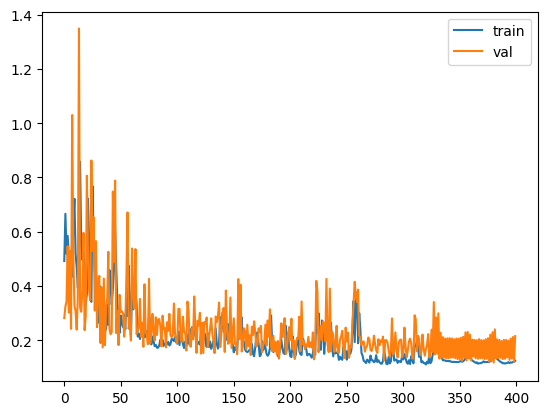

In [111]:
plt.plot(all_train_loss, label="train")
plt.plot(all_valid_loss, label="val")
plt.legend()

In [112]:
# ARE WE PREDICTING THE TRAINING SET?
train_data_eval = DataLoader(train_dataset, 
        batch_size = len(train_dataset),
        shuffle=False, 
        )

train_eval_batch = get_next_batch(inf_generator(train_data_eval))

0.9768347236851886


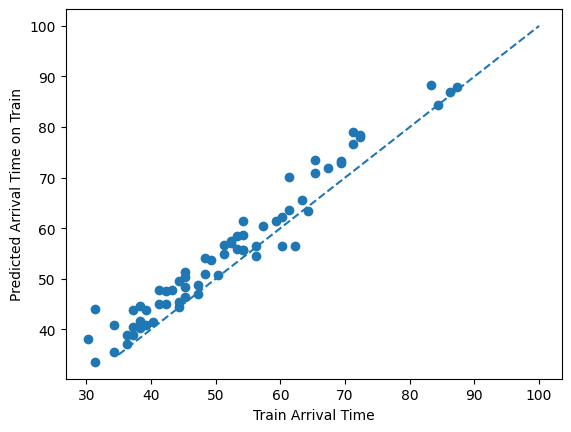

In [116]:
model.eval()
with torch.no_grad():
    train_preds_scaled = model(train_eval_batch[0]).cpu().numpy()

train_preds_unscaled = pt.inverse_transform(train_preds_scaled)
train_targets_all = train_eval_batch[2].cpu().numpy()

plt.scatter(train_targets_all[::40], train_preds_unscaled[::40])
plt.plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--')
plt.xlabel("Train Arrival Time")
plt.ylabel("Predicted Arrival Time on Train")

print(np.corrcoef(train_targets_all[::40].flatten(), train_preds_unscaled[::40].flatten())[1][0])

0.9645824611257613


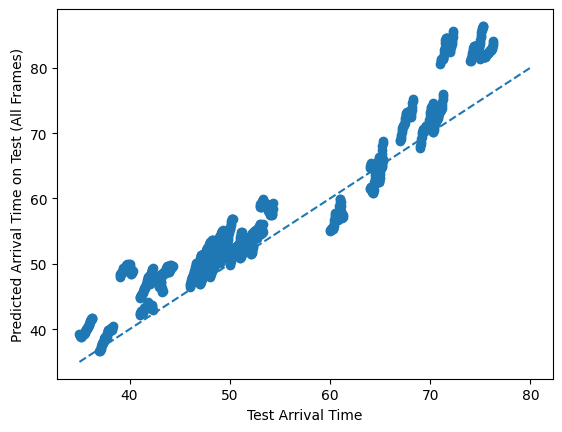

In [117]:
test_data_all = get_next_batch(inf_generator(test_dataloader))
# true_test_arrs = pt.inverse_transform(test_data_all[1].cpu().numpy())
true_test_arrs = test_data_all[2].cpu().numpy()
model.eval()
with torch.no_grad():
    test_preds = model(test_data_all[0].to(device)).cpu().numpy()

test_preds_unscaled = pt.inverse_transform(test_preds)

plt.scatter(true_test_arrs, test_preds_unscaled)
plt.plot(np.linspace(35, 80, 40), np.linspace(35, 80, 40), '--')
plt.xlabel("Test Arrival Time")
plt.ylabel("Predicted Arrival Time on Test (All Frames)")

print(np.corrcoef(true_test_arrs.flatten(), test_preds_unscaled.flatten())[1][0])

In [139]:
# test_data_all[0].shape, test_data_all[1].shape, test_data_all[2].shape

0.9663283815732326


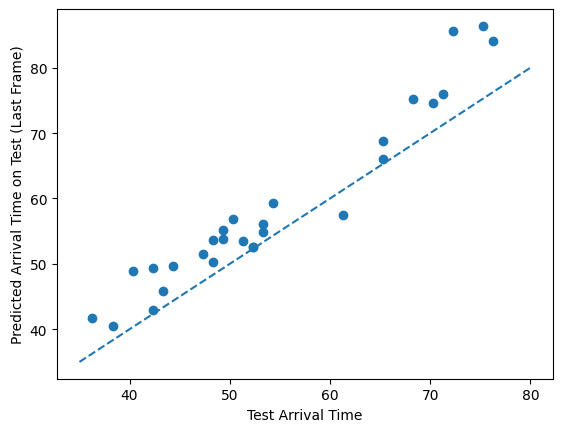

In [118]:
plt.scatter(true_test_arrs[::40], test_preds_unscaled[::40])
plt.plot(np.linspace(35, 80, 40), np.linspace(35, 80, 40), '--')
plt.xlabel("Test Arrival Time")
plt.ylabel("Predicted Arrival Time on Test (Last Frame)")
print(np.corrcoef(true_test_arrs[::40].flatten(), test_preds_unscaled[::40].flatten())[1][0])

In [ ]:
# print(np.corrcoef(true_test_arrs.flatten(), test_preds_unscaled.flatten())[1][0])
print(np.corrcoef(true_test_arrs.flatten(), test_preds_unscaled.flatten())[1][0])

In [69]:
# Training Loop

In [70]:
# Predictions and plots